In [2]:
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')

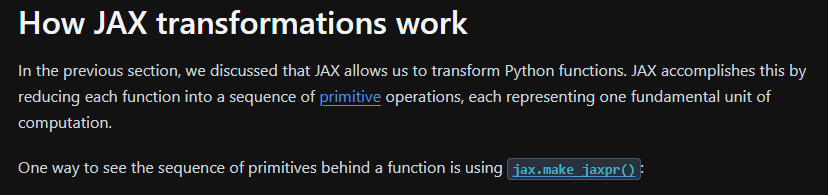

In [3]:
global_list = []

def log2(x):
  global_list.append(x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


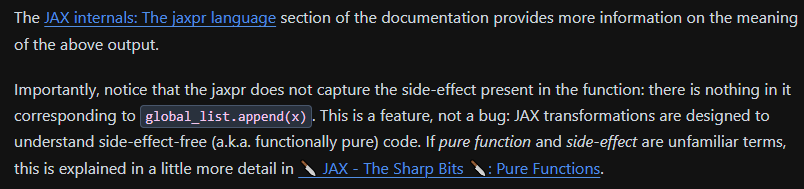

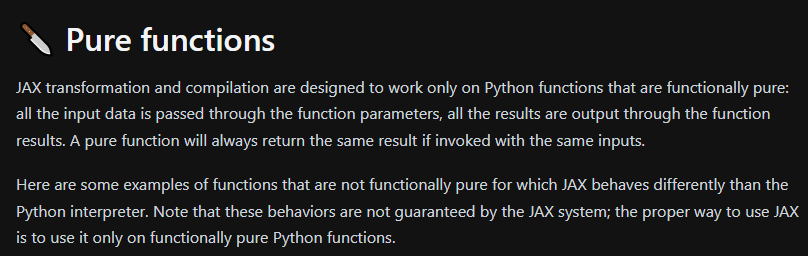

In [6]:
from jax import grad, jit
def impure_print_side_effect(x):
  print("Executing function")  # This is a side-effect
  return x

# The side-effects appear during the first run
print ("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compilation of the function
print ("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print ("Third call, different type: ", jit(impure_print_side_effect)(jnp.array([5.])))

Executing function
First call:  4.0
Second call:  5.0
Executing function
Third call, different type:  [5.]


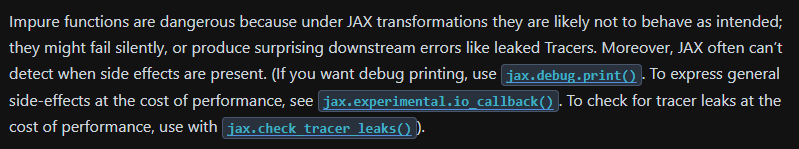

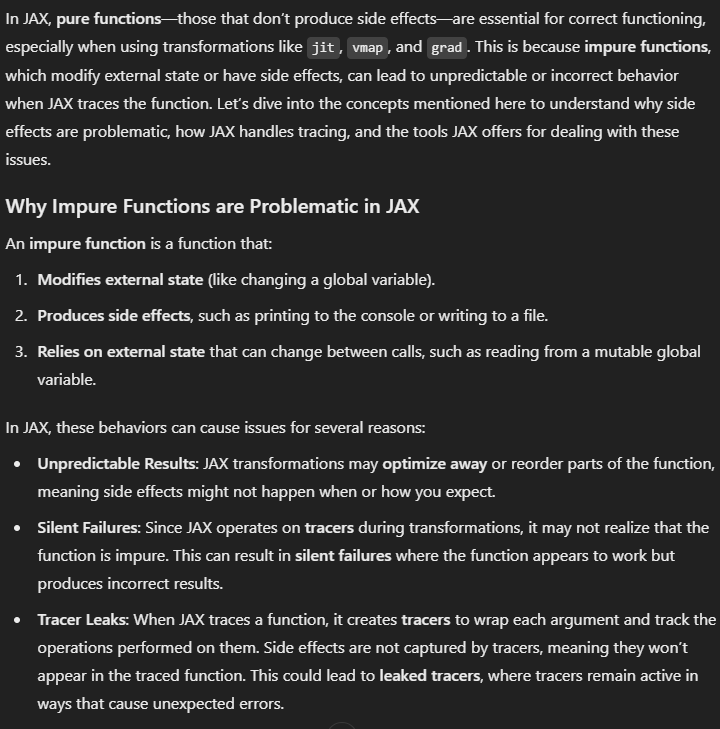

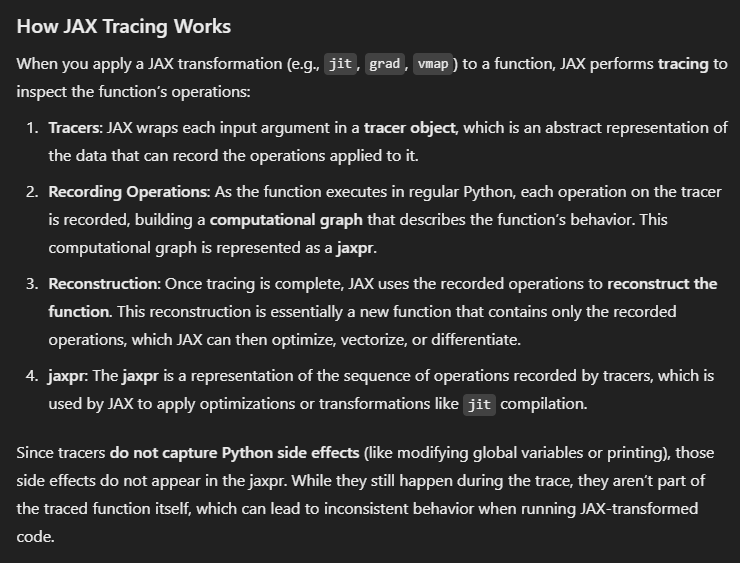

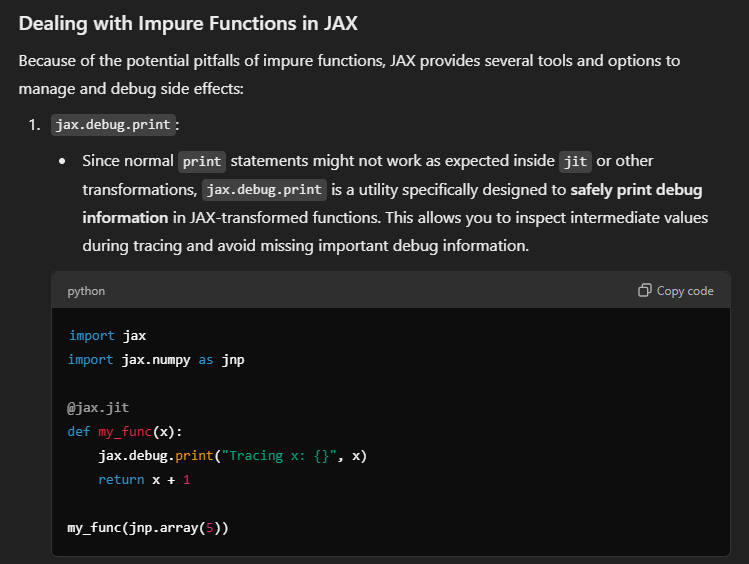

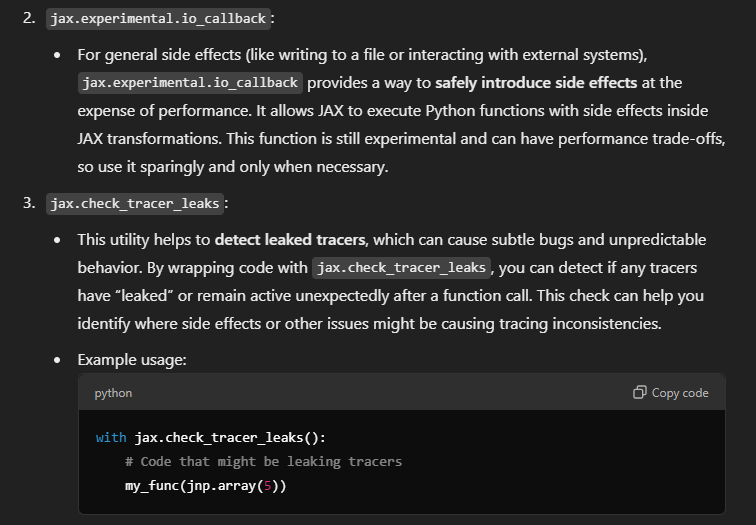

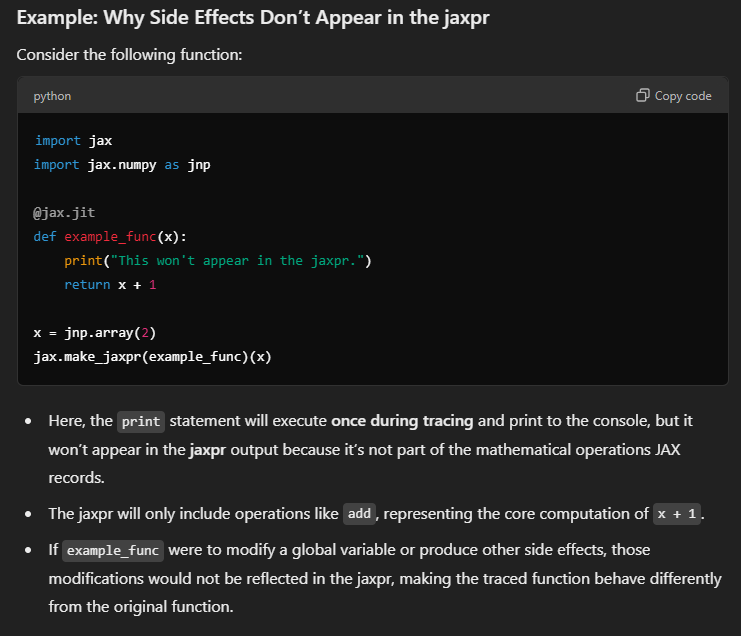

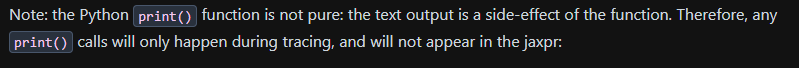

In [7]:
def log2_with_print(x):
  print("printed x:", x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2_with_print)(3.))

printed x: Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


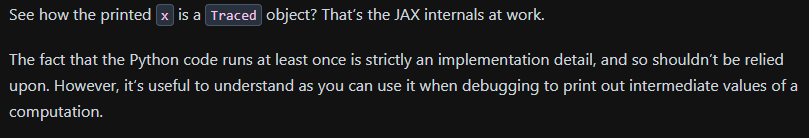

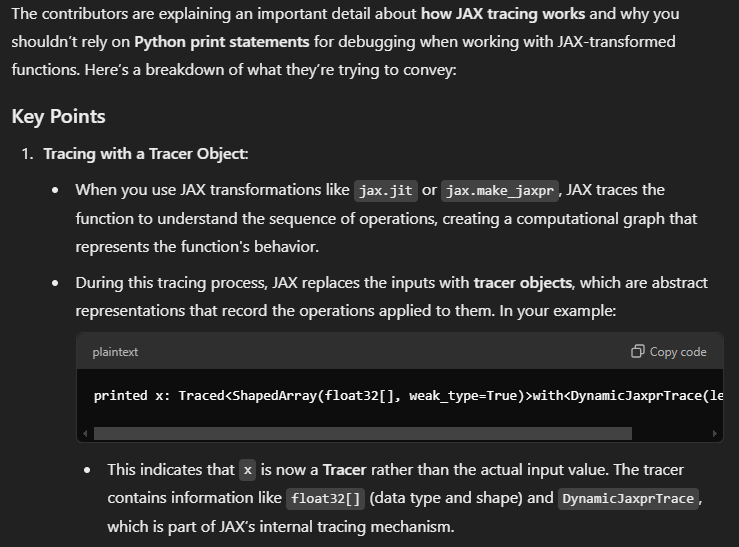

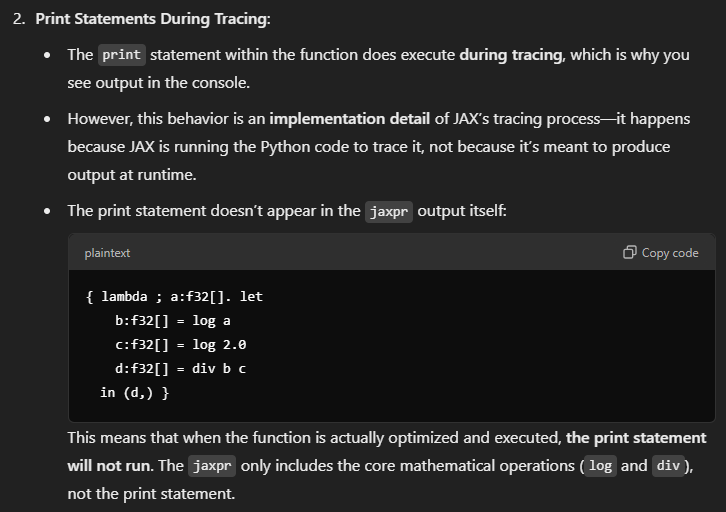

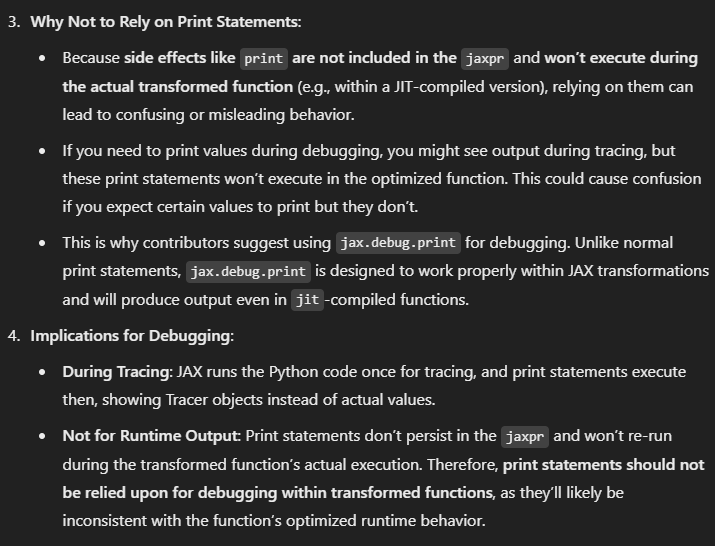

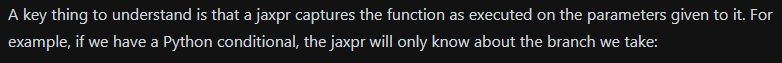

In [8]:
def log2_if_rank_2(x):
  if x.ndim == 2:
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2
  else:
    return x

print(jax.make_jaxpr(log2_if_rank_2)(jax.numpy.array([1, 2, 3])))

{ lambda ; a:i32[3]. let  in (a,) }


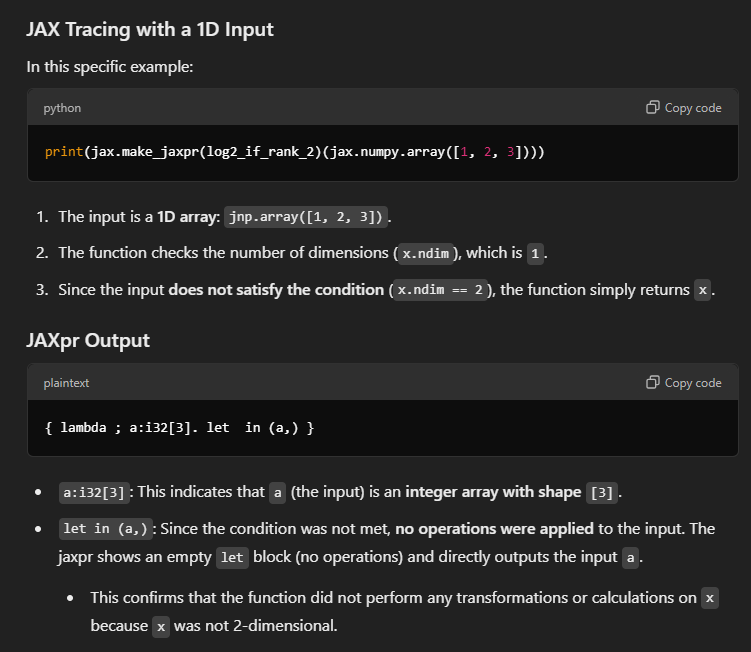

In [9]:
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

4.66 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


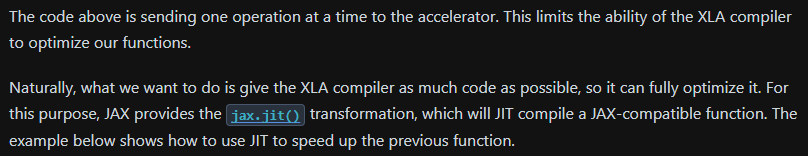

In [10]:
selu_jit = jax.jit(selu)

# Pre-compile the function before timing...
selu_jit(x).block_until_ready()

%timeit selu_jit(x).block_until_ready()

969 µs ± 82.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


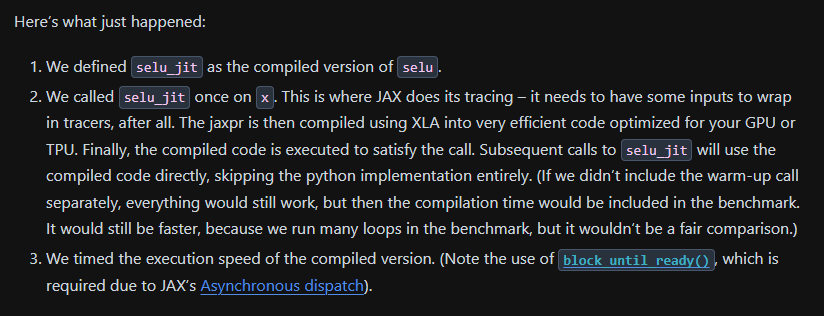

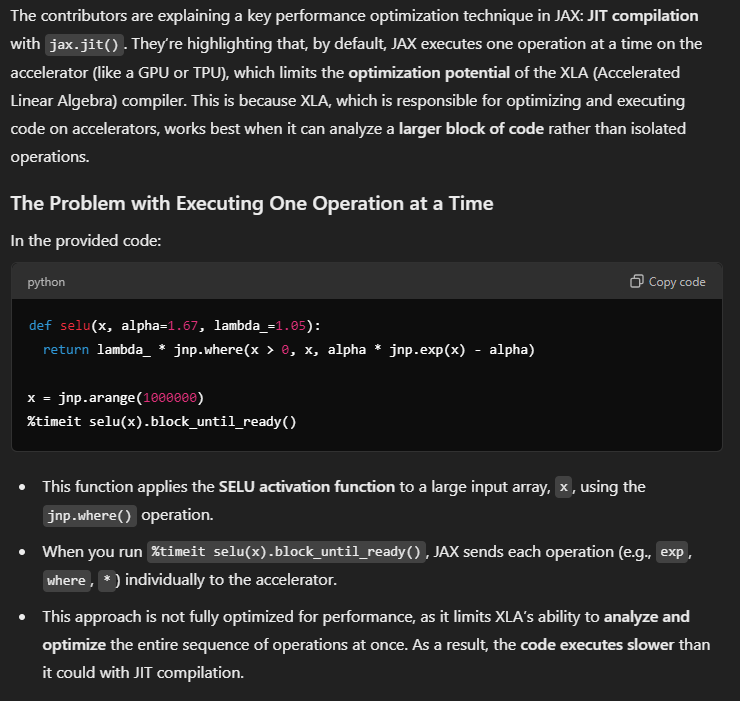

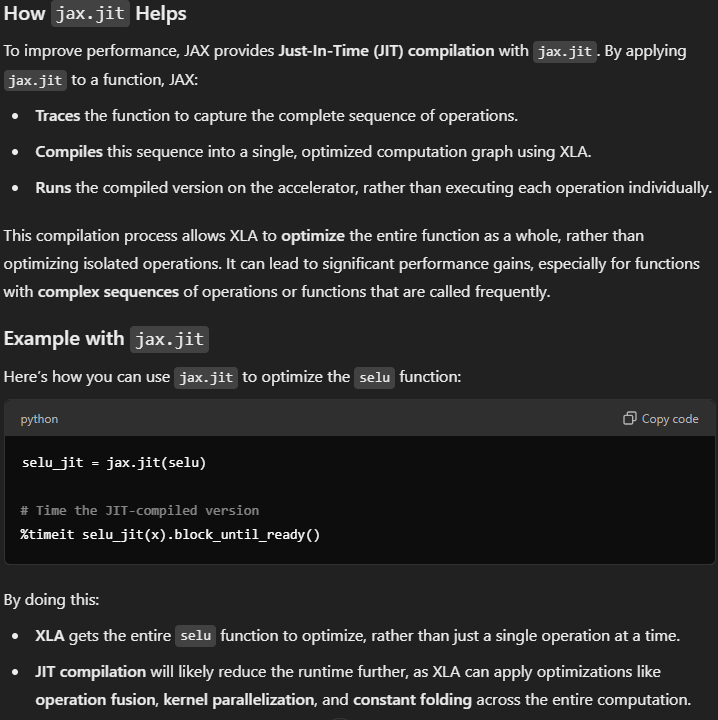

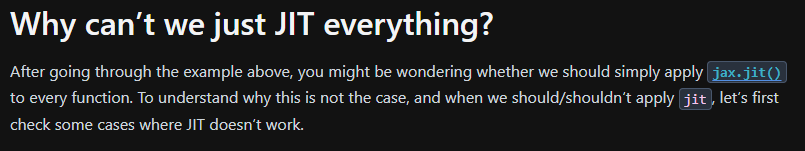

In [11]:
# Condition on value of x.

def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

jax.jit(f)(10)  # Raises an error

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function f at C:\Users\haadi\AppData\Local\Temp\ipykernel_22788\2956679937.py:3 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [12]:
# While loop conditioned on x and n.

def g(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

jax.jit(g)(10, 20)  # Raises an error

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function g at C:\Users\haadi\AppData\Local\Temp\ipykernel_22788\722961019.py:3 for jit. This concrete value was not available in Python because it depends on the value of the argument n.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

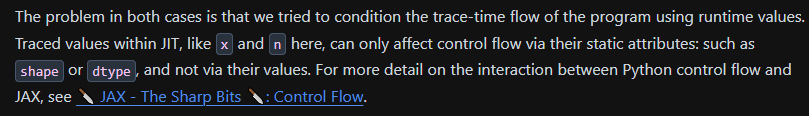

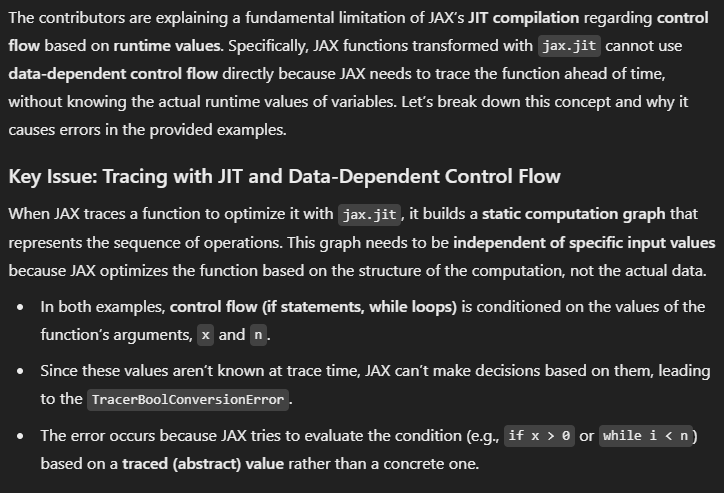

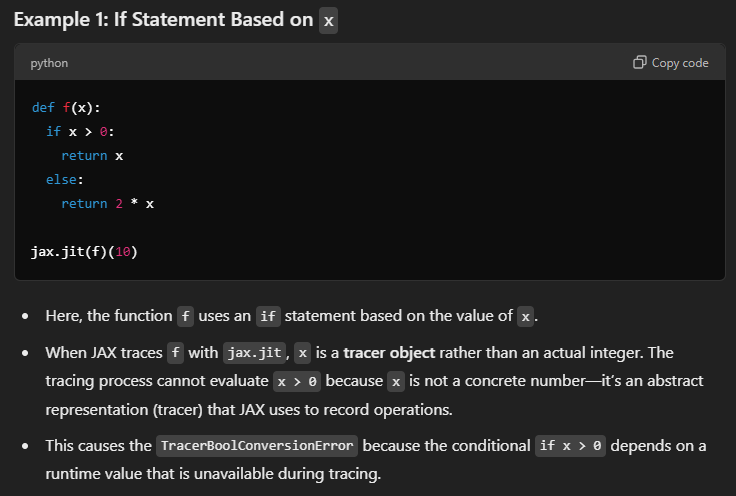

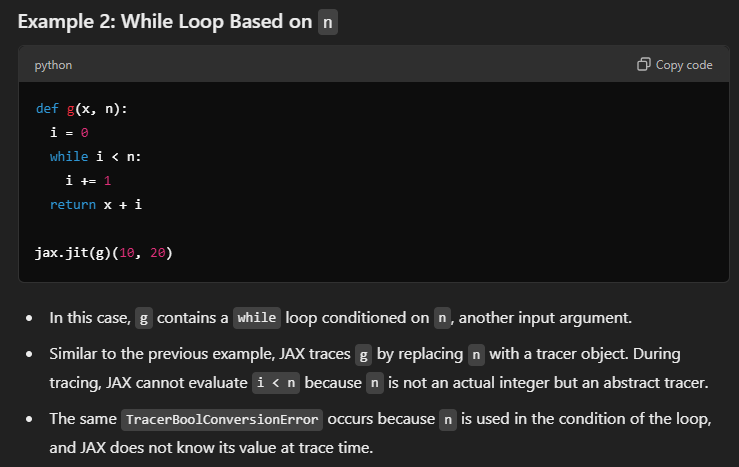

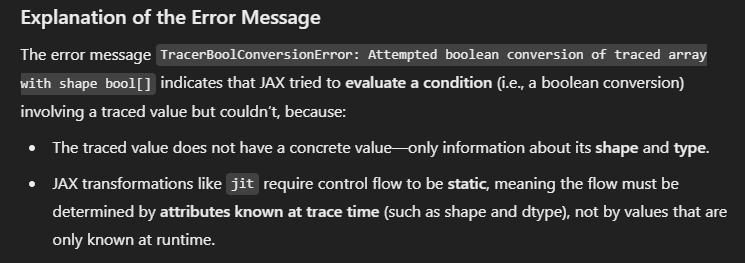

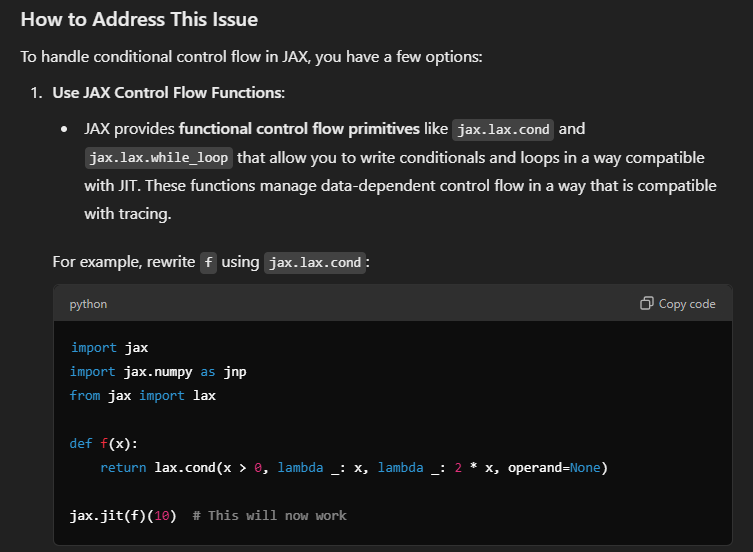

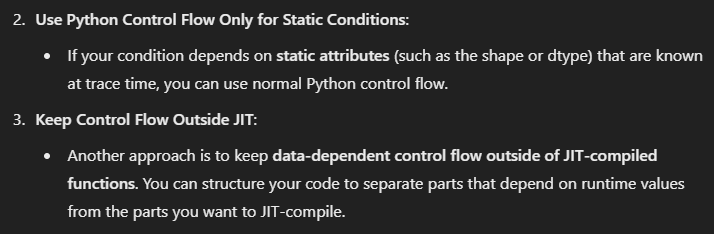

In [13]:
import jax
import jax.numpy as jnp
from jax import lax

def f(x):
    return lax.cond(x > 0, lambda _: x, lambda _: 2 * x, operand=None)

jax.jit(f)(10) 

Array(10, dtype=int32, weak_type=True)

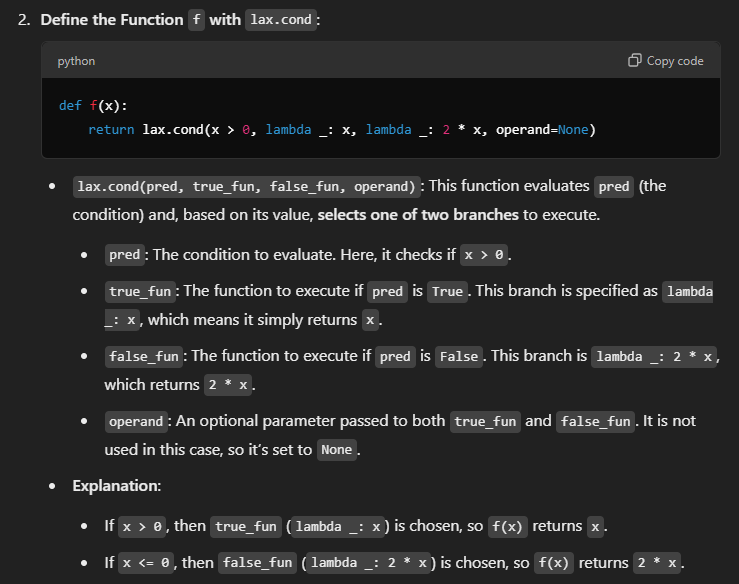

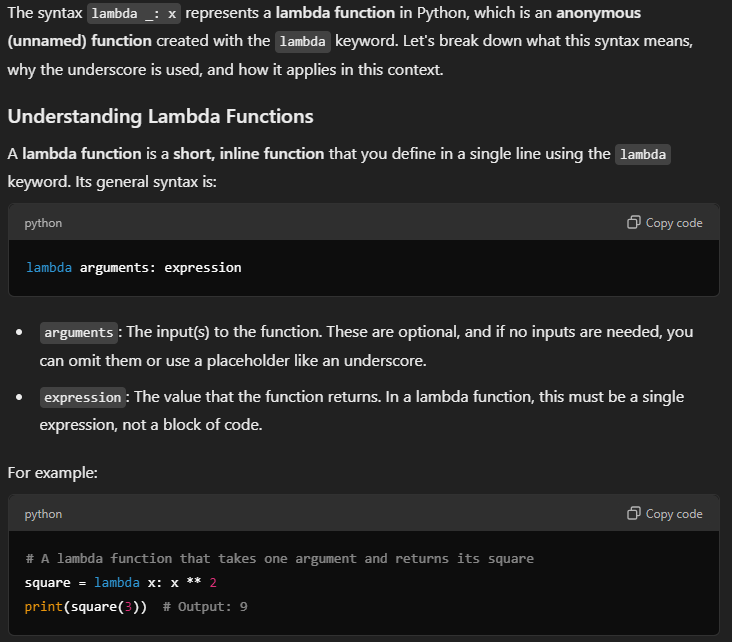

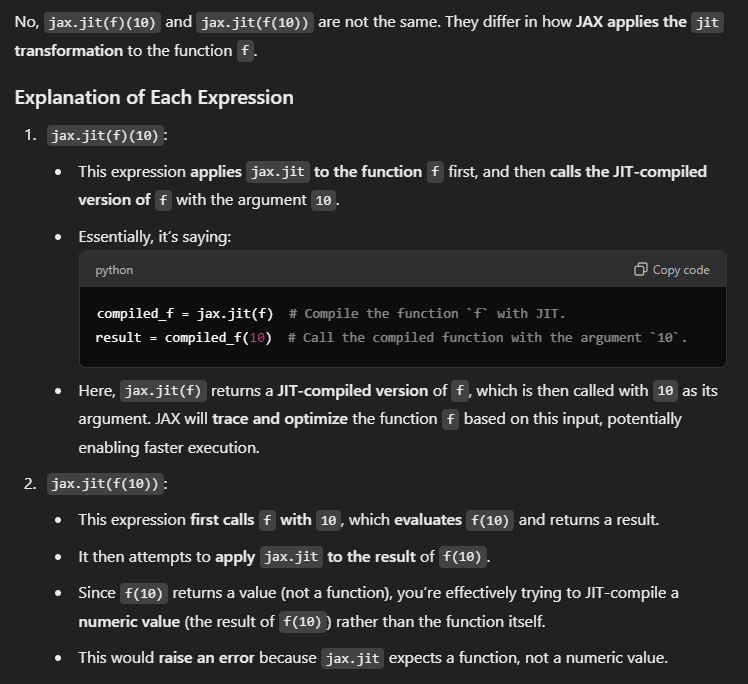

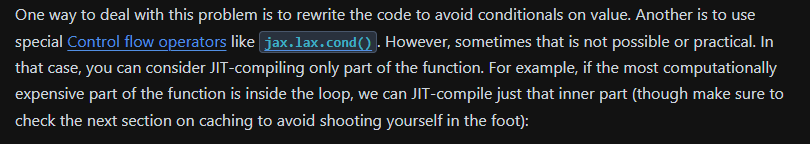

In [14]:
@jax.jit
def loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted(x, n):
  i = 0
  while i < n:
    i = loop_body(i)
  return x + i

g_inner_jitted(10, 20)

Array(30, dtype=int32, weak_type=True)

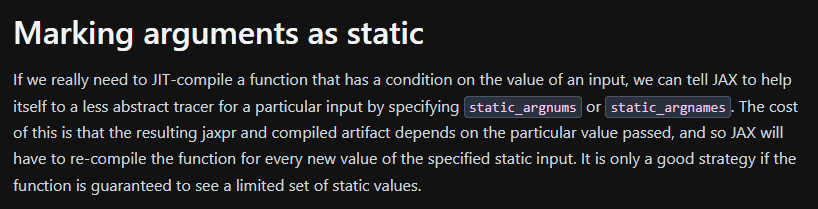

In [15]:
f_jit_correct = jax.jit(f, static_argnums=0)
print(f_jit_correct(10))

10


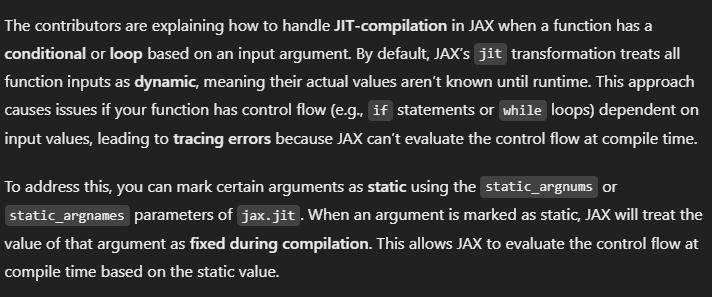

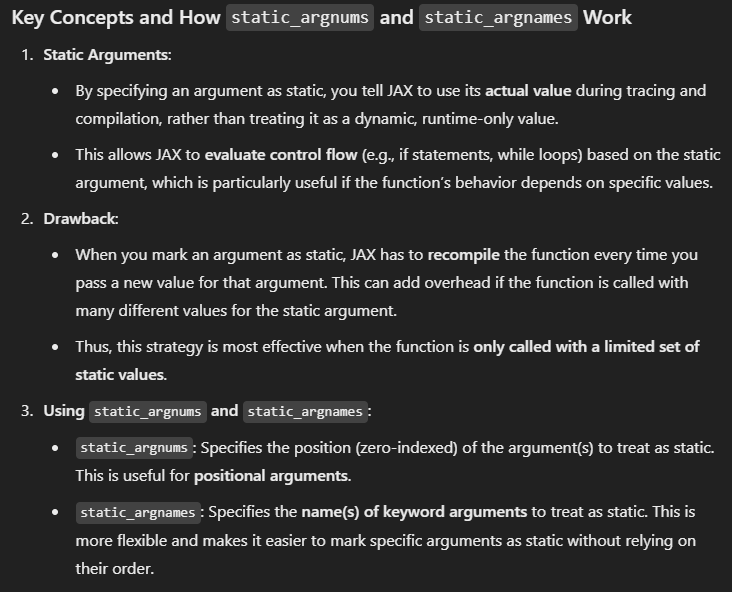

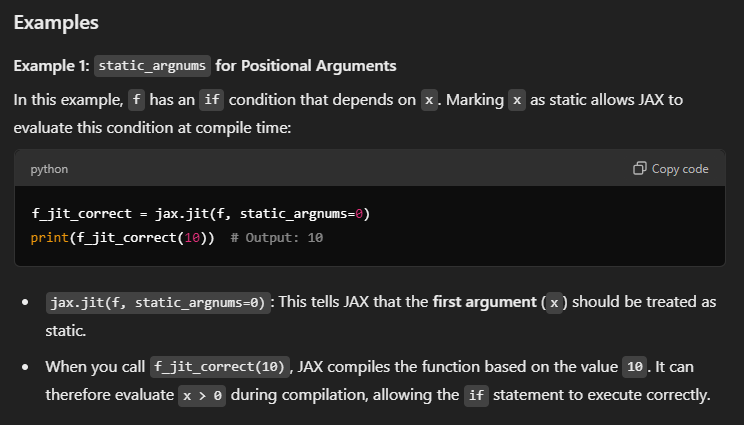

In [16]:
g_jit_correct = jax.jit(g, static_argnames=['n'])
print(g_jit_correct(10, 20))

30


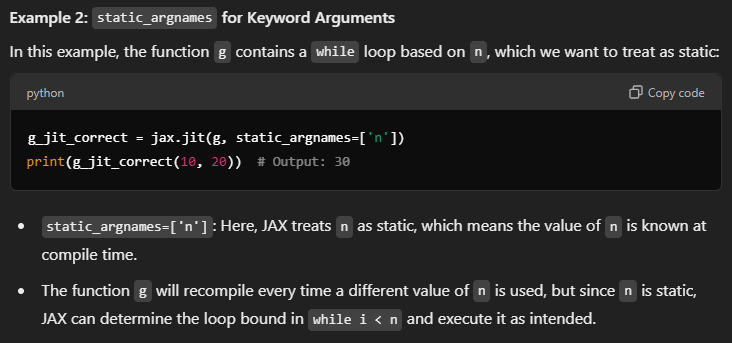

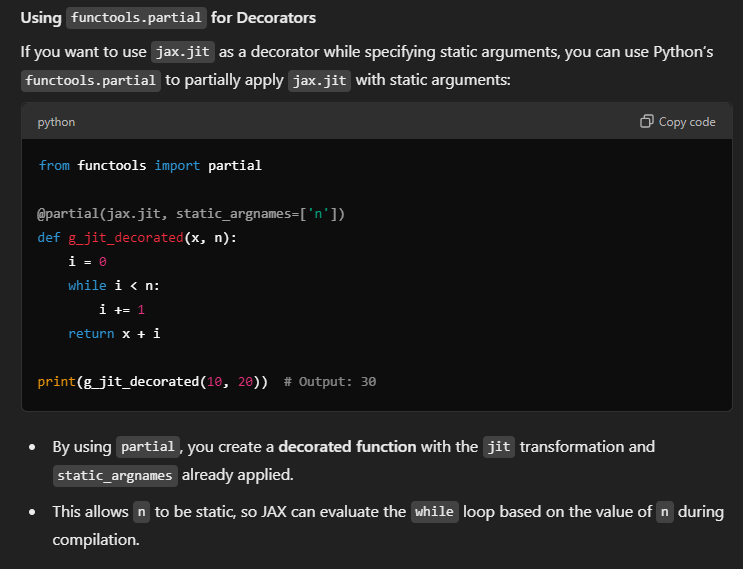

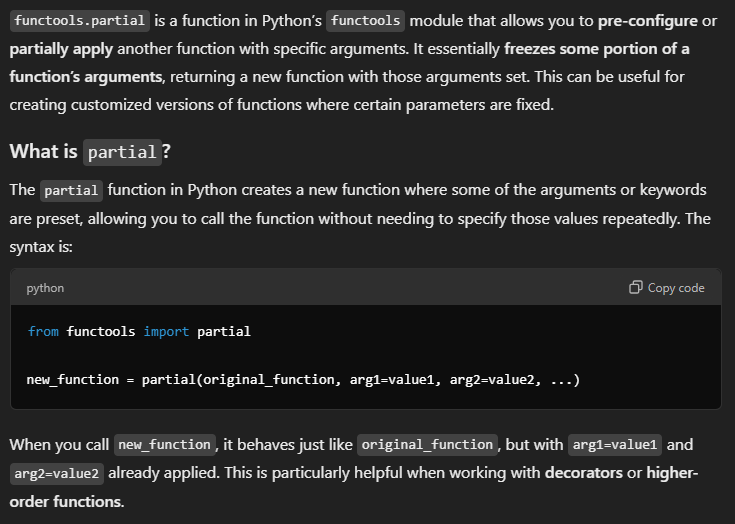

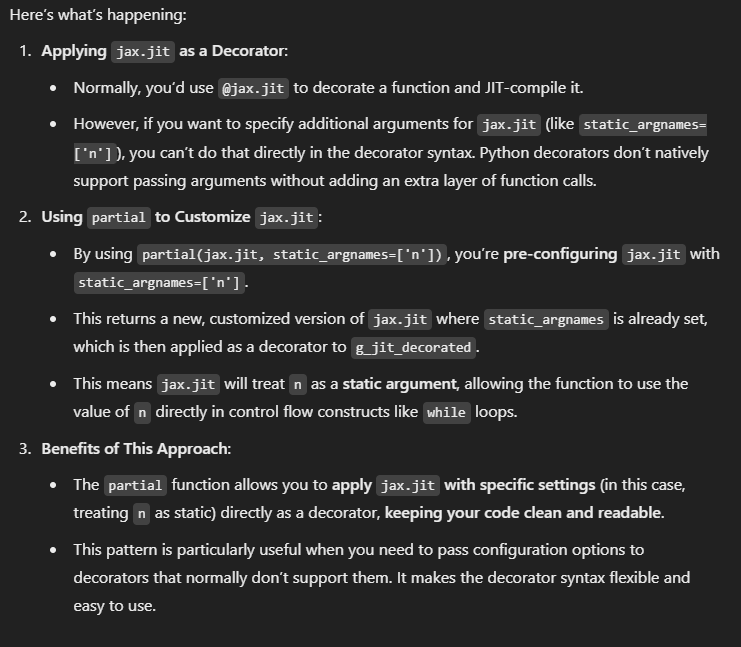

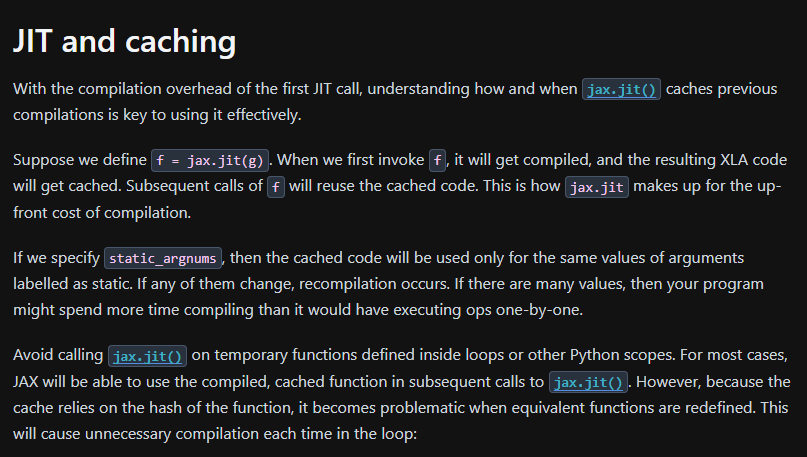

In [17]:
from functools import partial

def unjitted_loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted_partial(x, n):
  i = 0
  while i < n:
    # Don't do this! each time the partial returns
    # a function with different hash
    i = jax.jit(partial(unjitted_loop_body))(i)
  return x + i

def g_inner_jitted_lambda(x, n):
  i = 0
  while i < n:
    # Don't do this!, lambda will also return
    # a function with a different hash
    i = jax.jit(lambda x: unjitted_loop_body(x))(i)
  return x + i

def g_inner_jitted_normal(x, n):
  i = 0
  while i < n:
    # this is OK, since JAX can find the
    # cached, compiled function
    i = jax.jit(unjitted_loop_body)(i)
  return x + i

print("jit called in a loop with partials:")
%timeit g_inner_jitted_partial(10, 20).block_until_ready()

print("jit called in a loop with lambdas:")
%timeit g_inner_jitted_lambda(10, 20).block_until_ready()

print("jit called in a loop with caching:")
%timeit g_inner_jitted_normal(10, 20).block_until_ready()

jit called in a loop with partials:
214 ms ± 9.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
jit called in a loop with lambdas:
225 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
jit called in a loop with caching:
2.06 ms ± 93.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
